--- 
Project for the course in Computational Statistics | Summer 2021, M.Sc. Economics, Bonn University | [Philipp Schreiber](https://github.com/pcschreiber1)

# Variable Selection with High-Dimensional Low-Quality Data
## A comparison of LASSO and Random Forest. <a class="tocSkip">   
    
    
---

#### Downloading and viewing this notebook:

* The best way to view this notebook is by downloading it, the repository is located on [GitHub](https://github.com/pcschreiber1/Comp_Stat_Project).

<h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li>
    
<li><span><a href="#2.-High-dimensional-statistics-and-Variable-Selection" data-toc-modified-id="2.-High-dimensional-statistics-and-Variable-Selection-2">2. High-dimensional statistics and Variable Selection</a></span></li>
    
<div class="toc"><ul class="toc-item">
<li><span><a href="#2.1-The-Lasso" data-toc-modified-id="2.1-The-Lasso-2.1">2.1 The Lasso</a></span></li>

<li><span><a href="#2.2-Variable-Selection-using-Random-Forests" data-toc-modified-id="2.2-Variable-Selection-using-Random-Forests-2.2">2.2 Variable Selection using Random Forests</a></span></li>  
</ul>
    
<li><span><a href="#3.-Simulation-Study" data-toc-modified-id="3.-Simulation-Study-3">3. Simulation Study</a></span></li>
    
<div class="toc"><ul class="toc-item">
<li><span><a href="#3.1-Set-up" data-toc-modified-id="3.1-Set-up-3">3.1 Set-up</a></span></li>
    
<li><span><a href="#3.2-Simulation-Study-I---Baseline" data-toc-modified-id="3.2-Simulation-Study-I---Baseline-3.2">3.2 Simulation Study I - Baseline</a></span></li>
    
<li><span><a href="#3.3-Simulation-Study-II---Correlation-Structure" data-toc-modified-id="3.3-Simulation-Study-II---Correlation-Structure-3.3">3.3 Simulation Study II - Correlation Structure</a></span></li>
    
<li><span><a href="#3.4-Simulation-Study-III---Weak-Sparsity" data-toc-modified-id="3.4-Simulation-Study-III---Weak-Sparsity-3.4">3.4 Simulation Study III - Weak Sparsity</a></span></li>
</ul>

<li><span><a href="#4.-Application:-Macroeconomic-Growth-Model" data-toc-modified-id="4.-Application:-Macroeconomic-Growth-Model-4.">4. Application: Macroeconomic Growth Model</a></span>

<li><span><a href="#5.-Conclusion" data-toc-modified-id="5.-Conclusion-5">5. Conclusion</a></span></li>
    
<li><span><a href="#6.-References" data-toc-modified-id="6.-References-6">6. References</a></span></li></div>
    
<li><span><a href="#Appendix" data-toc-modified-id="Appendix">Appendix</a></span></li></div>

In [2]:
# Imports
suppressMessages(library(MASS))
suppressMessages(library(stats))
suppressMessages(library(Matrix))
suppressMessages(library(glmnet)) #for LASSO
suppressMessages(library(Rcpp)) #required by VSURF
suppressMessages(library(VSURF))#for RF
suppressMessages(library(ggplot2)) #for plotting
suppressMessages(library(dplyr)) #for plotting
suppressMessages(library(cowplot)) #for plotting
suppressMessages(library(readxl)) #for reading excel files
suppressMessages(library(knitr)) #for the table
suppressMessages(library(kableExtra)) #for the table
suppressMessages(library(IRdisplay)) #for displaying html output
suppressMessages(library(repr)) #for notebook settings

In [3]:
#Import auxiliary functions
source("auxiliary/simulation_functions.R", local=FALSE)
source("auxiliary/application_functions.R", local=FALSE)

set.seed(456)

# Setting display options
default = list(repr.plot.width = 14, repr.plot.height = 10, repr.plot.res = 600, repr.plot.quality = 90)
options(default)

#Controlling simulation studies
rerun = FALSE

---
## 1. Introduction
---

In empirical analyses, variable selection is one of the most common challenges researchers face. With the increasing availability of high-dimensional datasets, many data driven approaches to variable/feature selection have been developed and are gaining traction, including in the social sciences. The Least-Absolute-Shrinakge-Operator's (Lasso) simply interpretationa dn high computation efficiency have made it very popular among economists, when dealing with high-dimensional data (Desboulets, 2018). Recently, Bertismas et al. (2016) and Hastie et al. (2017) compared the Lasso's performance to modern "best-subset" selection techniques and found that, due to shrinkage methods' efficient variance reduction, the Lasso can outperform these more computationally expensive techniques if the data is very noisy.

In this notebook, I contribute to the analysis of variable selection under high-dimensional low quality data by comparing the performance of the LASSO and relaxed Lasso to another method designed for efficient varaince reduction: Random Forests (RF). RF-based variable selection procedures have become especially popular in bio-medical sciences, but, so-far, are still uncommon in many strands of economics. Here we apply the data-driven technique of Genuer et al. (2010), which is implemented in the `VSURF` package.  Three different simulation studies are conducted which closely emulate real-world macro-economic data and each illustrate the methodologies' behaviour under different challenges. Importantly, given the liability of direct comparisons of parametric and non-parametric methods to the underlying data generating process (DGP), we here focus on the techniques' relative performance under different levels of noise clarity. The discussion is complemented by an application to Sala-I-Martin's (1997b) famous "millions" data set, which has frequently been used to showcase variable selection strategies for macro-economic growth models.

The rest of the notebook then proceeds as follows: after a detailed discussion of the role of variable selection in high-dimensional data and a formal introduction of the concept of SNR, the standard Lasso and relaxed Lasso methods are introduced. Following Meinshausen (2007), I explain the soft-thresholding of the Lasso estimator and use the `glmnet` package to showcase how the relaxed Lasso avoids spurious density by separating control of shrinkage and sparsity. I then proceed to introduce random forests, emphasising the bias-variance trade-off they entail. Subsequently, I turn to the two-step variable selection strategy of Genuer et al., again drawing on the relevant `R` package for illustration. Section 3 is devoted to the simulation studies and discusses their results. Highlighting the extraordinary stability of the random forest results, I finally turn to the application: after giving a brief introduction to variable selection in the empirical macro-economic growth literature, the three methods are applied to the "millions" data and compared to the subset selected by Sala-I-Martin.

---
## 2. High-dimensional statistics and Variable Selection
----

The term “high-dimensional” refers to a broad spectrum of scenarios where the number of covariates $p$ is allowed to grow with the number of observations $n$, sometimes even exceeding it such that $n<<p$. While it is well-known that the ordinary least squares estimator ceases to be applicable once $n<p$, the statistical challenges related to a relative increase in $p$ – often grouped together as “the curse of dimensionality” – apply more broadly.  As Fan and Lv (2009) explain, these relate to the “statistical accuracy, model interpretability, and computational complexity” researchers face. For example, identifying the **best subset** model requires the estimation of $2^p$ specifications – which quickly becomes intractable, including for scenarios which have become standard today (see Bertsimas et al., 2016 for an alternative). In addition, once $n<p$ the covariance matrices cannot be estimated without applying additional assumptions, like sparsity (Donoho, 2000). More general "curses of dimensionality" include face spurious collinearity and noise accumulation, which further impair model estimation (Fan and Lv, 2009). For a braod overview on the challenges of high dimensionality, see Donoho (2000), Johnstone et al. (2009) and Fan and Li (2006).

Faced with these issues, the exploitation of hypothesised **sparsity** has become extremely popular for dealing with high-dimensional data.  The idea is that, if only a subset $k$ of all covariates $p$ truly influences the dependent variable, correctly identifying these can improve estimation accuracy, interpretability and reduce computational costs (Fan and Lv, 2009). That is why variable selection has a special role in many applications of high-dimensional data analysis. However, as mentioned above, traditional estimation methods can run into error in the face of high-dimensionality, including those for variable selection. As a result, different techniques have been developed precisely for these scenarios. In what follows, we are introducing and comparing the variable selection properties of shrinkage operators and a two-step procedure based on random forests (RF).

Before we proceed, it is important to note that there is no single perfect procedure. On the contrary, as Hastie et al. (2017) emphasise:

>“Different procedures have different operating characteristics, i.e., give rise to different bias-variance tradeoffs as we vary their respective tuning parameters. In fact, depending on the problem setting, the bias-variance tradeoff provided by best subset selection may be more or less useful than the tradeoff provided by the lasso.” (p.582)

One such structure is a data set’s signal-to-noise ratio (SNR) and, in the present analysis, we follow Hastie et al. (2017) in making it the basis of comparison for the different methods. Low SNR is one instance of “low data quality” and describes a scenario where the variation in the explanatory variables is low in comparison to the variation of the dependent variable. More formally, for a linear model of the form $y = X' \beta + \varepsilon$ with $\varepsilon_{i} \sim iid N(0,\sigma{2})$, the SNR is given by:

$$SNR = \frac{var( X' \beta)}{\sigma^{2}}$$

As a result, for a given SNR, if we hold the choice of the coefficients and the distribution of explanatory variables fixed, a higher SNR implies a higher variance of the error term. Now, what Hastie et al. are referring to is that "best-subset selection" naturally has a very low bias, but in noisy settings methods such as Lasso can often deliver better results, since they trade-in some of the bias for a substantial reduction in variance. In this notebook we zoom-in on this bias-variance trade-off and explicitly compare the Lasso to another method entailing an efficient bias-variance trade-off: random forests.

<h3><u>2.1 The Lasso</u></h3>

The Lasso belongs to the class of Shrinkage Methods (also known as Regularisation Methods) and, by constraining the coefficient estimates, is able to fit a linear model including all $p$ predictors, even if $n<p$. Penalized regressions can take many forms and different penalties continue to be devised to accommodate specific demands. Originally proposed by Tibshirani (1996), the class of Lasso estimators is known for their special property of shrinking coefficient estimates exactly to zero, effectively creating a sparse model estimate. In this sense, the Lasso estimators can be understood as a convexified approximation to the non-convex problem of best subset selection (see Bertsimas et al., 2016; Hastie et al., 2017):
Let $X = (X^1,…,X^p)$ be a $p$ dimensional predictor variable and $Y$ a response variable, the Lasso estimator is defined for $\lambda \in [0, \inf]$ and $\gamma =1$ as

$$ \hat{\beta}^{\lambda, \gamma} = arg \min_{\beta} \frac{1}{n} \sum^{n}_{i=1} (Y_i – X_{i}^{T} \beta)^2 + \lambda \lVert \beta \rVert_{\gamma}  $$

where $\lVert \beta \rVert_{\gamma}$ corresponds to the $l_{\gamma}$-norm. For $\gamma = 0$, this estimator is equivalent to the non-convex problem of best sub-set selection. The Lasso’s ability to correctly identify the true sparse model critically depends on an appropriate choice of the penalty term $\lambda$, with too low values leading to excessive density, while for high-enough penalties all estimated coefficients are set to zero. In practice, this tuning parameter is chosen by  cross-validation.

It is important to note that the penalty term $\lambda$ applies to all coefficients, which causes the true coefficients to be shrunken, as well. Indeed, this is the basis for the Lasso’s **bias-variance trade-off**: as Tibshirani (1996) explained, best-subset selection is a discrete method (variables are either selected or dropped) and, while achieving very low bias, its results suffer from very large variance. This is because small changes in the data can lead to very different models, which can strongly impair prediction accuracy. Instead, for the Lasso, larger values of $\lambda$ decrease the model flexibility which causes a variance decrease at the cost of an increase in bias, as described above. While other shrinkage methods such as the Ridge regression also trade variance for bias, their inability to set coefficients exactly to zero means that they do so less efficiently than the Lasso if the true model is sparse. 

In their recent paper Hastie et al. (2017) explain this as the difference in “’aggressiveness’ in selecting and estimating the coefficients in a linear model” (p.582). Responding to Bertismas et al. (2016), they demonstrate that in particular in noisy settings, aggressive methods such as best-subset and step-wise selection perform worse than less-aggressive ones, such as the Lasso estimator. However, the authors also show that the Lasso’s lack of aggressiveness can become problematic: for high-enough levels of SNR, penalizing already low coefficients such that they are exactly zero might incur too much shrinkage on the coefficients of the true coefficients and, hence, be too costly in terms of prediction error. As a result, the Lasso estimator can tend to deliver denser models than necessary. That is why in 2007 Meinshausen developed the two-step algorithm of the **relaxed Lasso**, which undoes some of the shrinkage of the Lasso estimate.

<h3 style="color:SlateGray;">Relaxed Lasso</h3>

As described above, in the standard Lasso the tuning parameter $\lambda$ controls both the i) number of non-zero coefficients and ii) the shrinkage on all coefficients. The relaxed Lasso estimator proposes to separate control of model sparsity and shrinkage by applying the Lasso a second time. More precisely, first all ordinary Lasso solutions are computed resulting in $m$ sub-sets of models $M_m$, each with a corresponding $\lambda_i$ for $i \in [1, m]$. In a second step, the Lasso is applied to each subset and the results are calculated up to the corresponding $\lambda_i$. The relaxed Lasso solutions for all penalty parameters are given by the union of these sets (for further details, see Meinshausen, 2007).
Following Meinshausen (2007), the relaxed Lasso estimator is defined for $\lambda \in [0, \inf)$ and $\phi \in (0,1]$ as

$$ \hat{\beta}^{\lambda, \phi} = arg \min_\beta \frac{1}{n} \sum^{n}_{i=1} (Y_i – X_{i}^{T}  {\beta * 1_{M_{\lambda}} })^2 + \phi \lambda \lVert \beta \rVert_{1}$$

where $1_{M_{\lambda}}$ is the indicator function of the set of variables $M_{\lambda} \subset (1,…,p)$ so that for all $k \in \{1,…,p\}$ we have $\{\beta * 1_{M_{\lambda}} \}_{k} = \left\{\begin{array}{ll}{0} & {\text { if } k \notin M_{\lambda}} \\ \beta_k & {\text { if } k \in M_{\lambda}}\end{array}\right.$



Because only predictor variables in the set $M_{\lambda}$ are considered for the relaxed Lasso, the variable selection is controlled by parameter $\lambda$. On the other hand, the “relaxation parameter” $\phi$ relaxes the shrinkage of the coefficients, with $\phi=1$ reducing to the ordinary Lasso (the case of $\phi=0$ corresponds to the Lars-OLS hybrid, for more, refer to Efron et al., 2004). We visualize this below using the `glmnet` package.

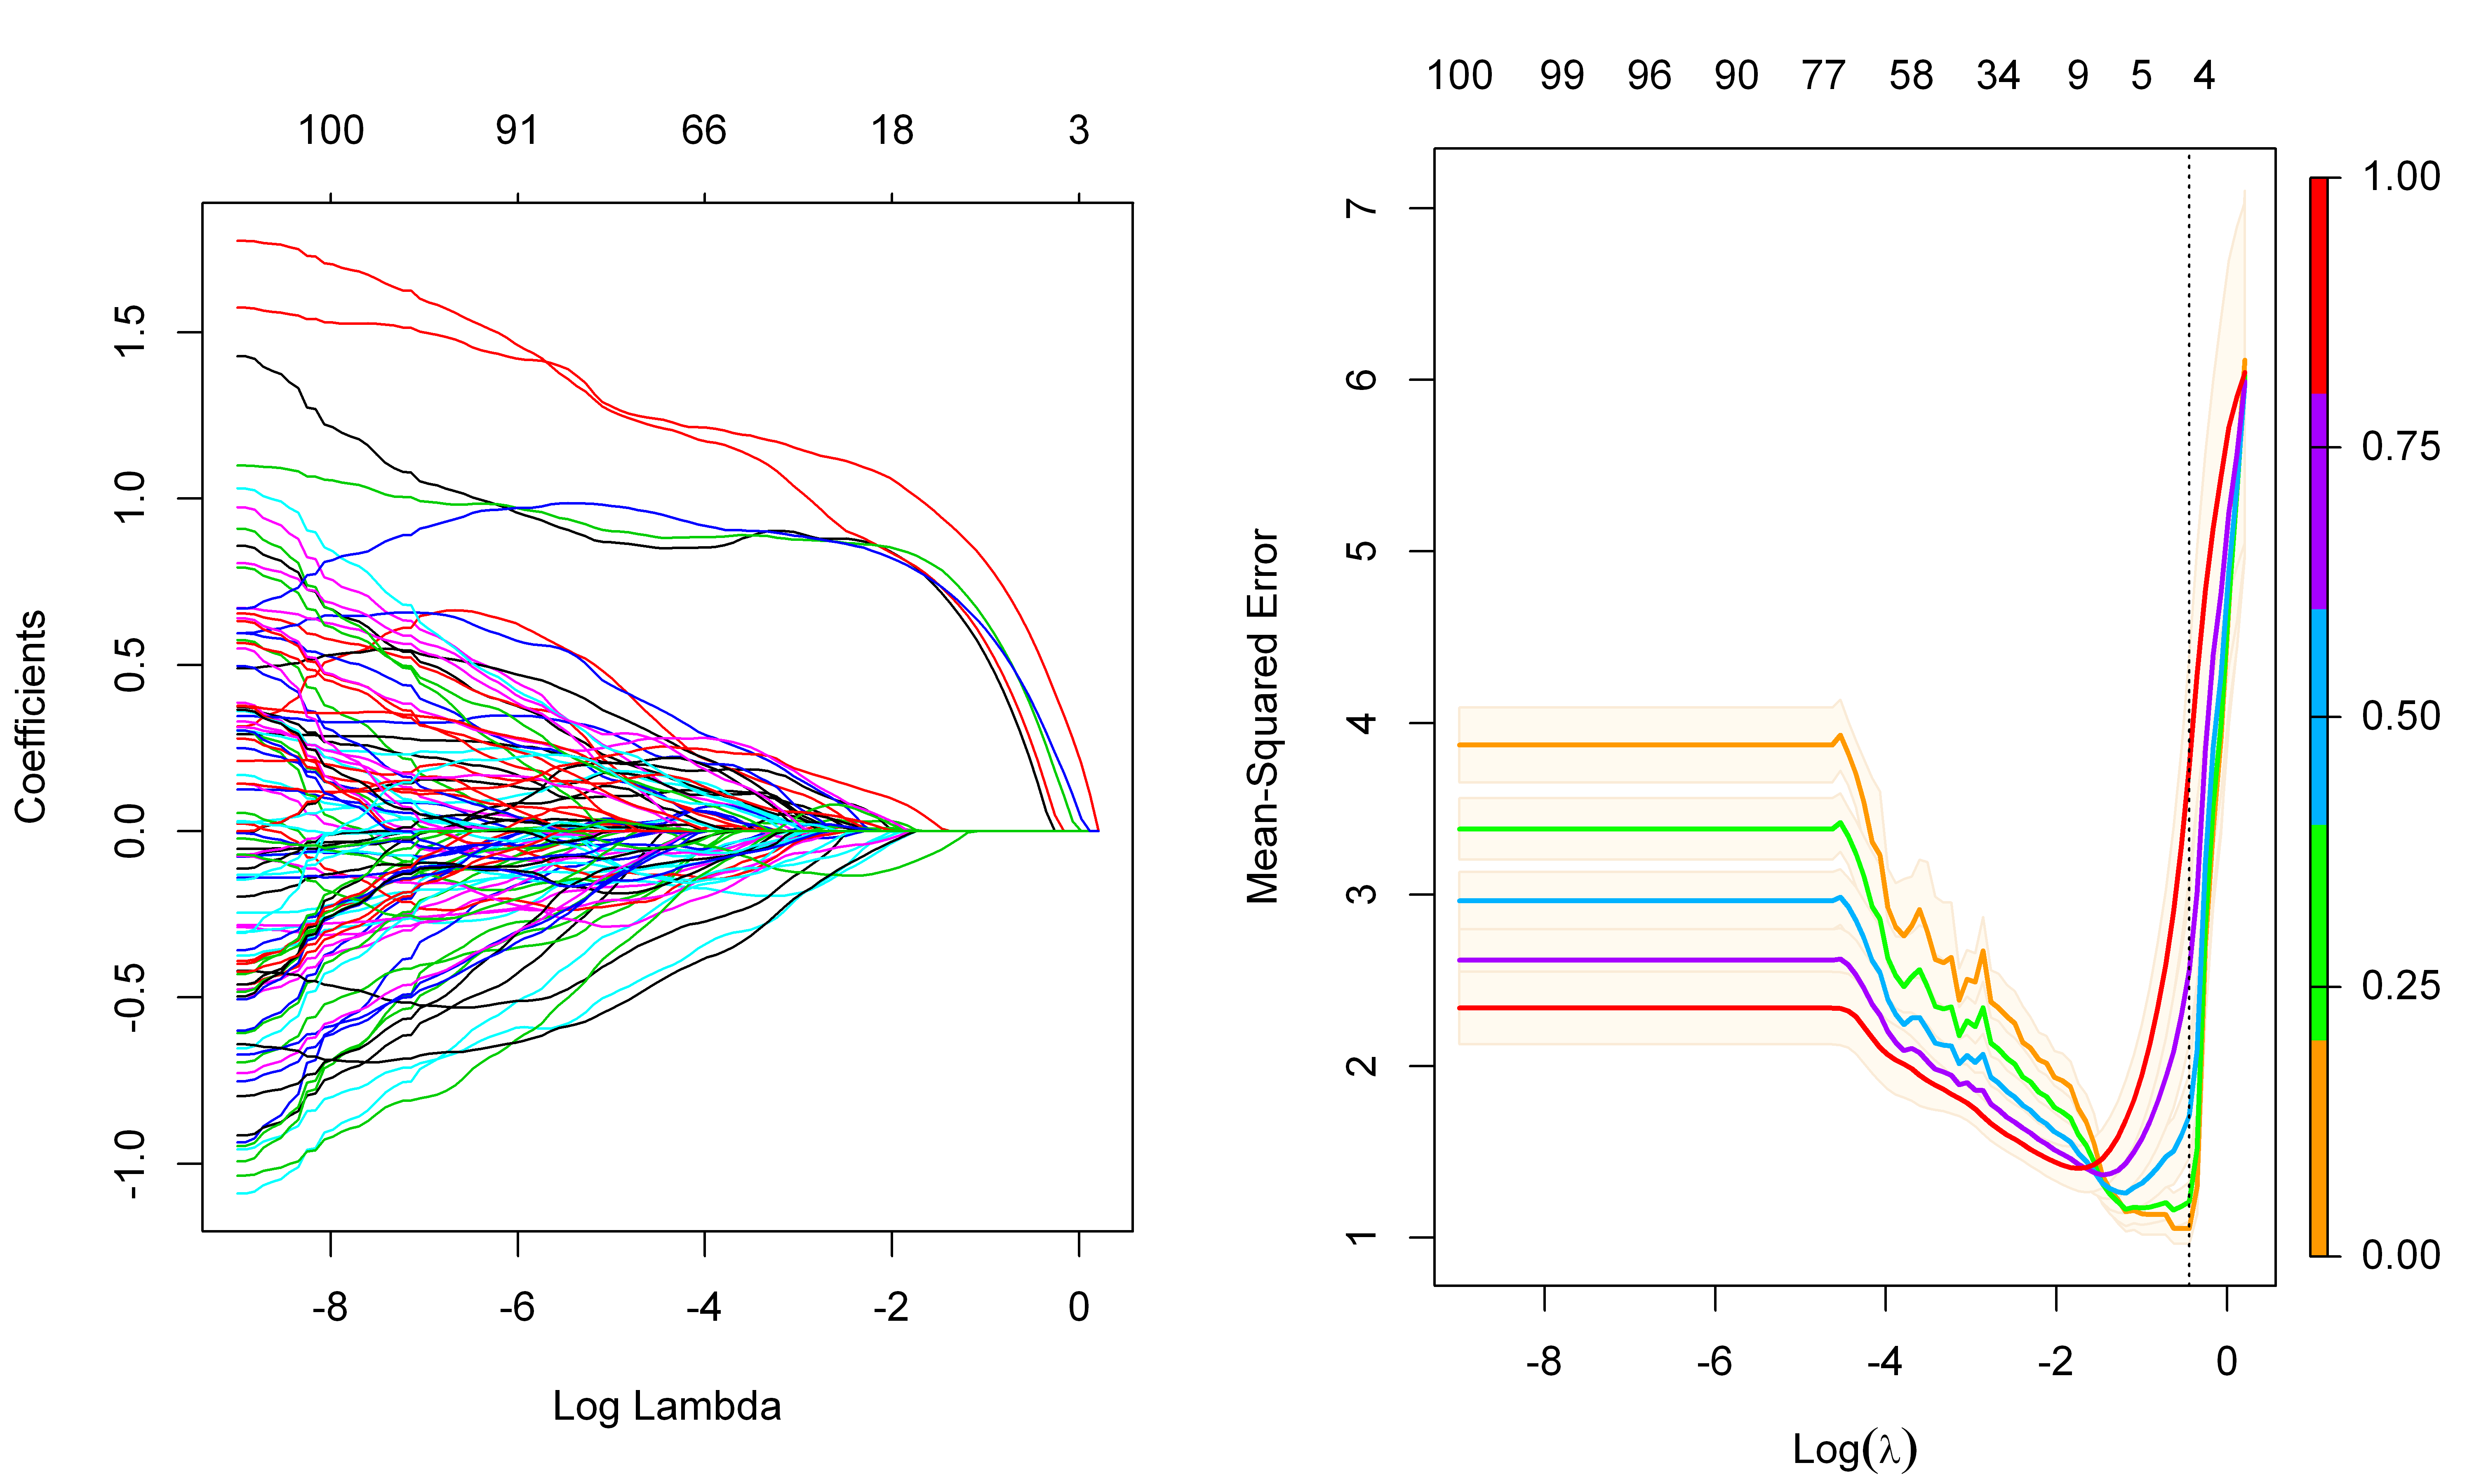

In [4]:
set.seed(456) # because of CV

# Generate Data
beta = beta_1(p=100,s=5)
df <- simulate(n=100, p=100, rho=0.5, beta=beta, SNR = 6)$df
x <- data.matrix(df[,-1]) #explan var, glmnet can't use dataframe
y <- data.matrix(df[,1]) #dependent var, glmnet can't use dataframe

Lasso = glmnet(x, y,intercept=FALSE, alpha=1)
rel_Lasso = cv.glmnet(x, y,intercept=FALSE, relax=TRUE)

# Plot results
options(repr.plot.width = 10, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(Lasso, xvar="lambda")
plot(rel_Lasso)
options(default)

In the first plot, we see that, because the model does so well in identifying the true predictors, most of the noise coefficients are very close to zero, even for very low penalty. In turn, the right plot shows the cross-validated MSE for the different levels of the penalty term $\lambda$ and each graph represents a different tuning parameter $\phi$ (in `glmnet` referred to as `gamma`). Tracing the red line corresponding to the Lasso, we see that a less sparse model is chosen, because shrinking already small coefficients to exactly zero is not worth the added shrinkage on the true predictors. Instead, considering the yellow graph for example, we can see how - in virtue of separating the two controls - , the relaxed Lasso does not face the same trade-off: the lowest MSE is reached for a higher value of the penalty term $\lambda$. Meinshausen nicely illustrates this using the simple orthogonal case: as shown in James et al. (2013, p. 255) under the orthogonal case the Lasso estimate takes the form

$$
\hat{\beta}_{j}^{L}=\left\{\begin{array}{ll}{\hat{\beta}_{j}^{OLS}-\lambda / 2} & {\text { if } \hat{\beta}_{j}^{OLS}>\lambda / 2 ;} \\ \hat{\beta}_{j}^{OLS}+\lambda / {2} & {\text { if } \hat{\beta}_{j}^{OLS} < \, - \lambda / 2;} \\ {0} & {\text { if }\left|\hat{\beta}_{j}^{OLS}\right| \leq \lambda / 2.}\end{array}\right.
$$

Here the **soft-thresholding** property (all coefficients are shrunken but some entirely to zero) of the Lasso is easy to see. The relaxed Lasso, on the other hand, provides solutions that includes a continuum of softness levels of thresholding:

$$
\hat{\beta}_{k}^{RL}=\left\{\begin{array}{ll}{\hat{\beta}_{k}^{OLS}-\phi \lambda} & {\text { if } \hat{\beta}_{k}^{OLS}>\lambda ;} \\ \hat{\beta}_{k}^{OLS}+\phi\lambda & {\text { if } \hat{\beta}_{k}^{OLS} < \, - \lambda;} \\ {0} & {\text { if }\left|\hat{\beta}_{k}^{OLS}\right| \leq \lambda.}\end{array}\right.
$$ 

That is, under the limiting case of $\phi = 0$ hard-thresholding is achieved (corresponding to the standard OLS) while under $\phi = 1$ the same soft-thresholding as the Lasso solution is delivered. While in the general case the shrinkage is a little more complicated, the main idea still holds: in the relaxed Lasso variable selection and shrinkage vis-á-vis the OLS estimator can be determined separately while lower levels of soft-thresholding are feasible.
Besides counteracting the undesired density in high-SNR cases, Meinshausen shows that the relaxed Lasso has several attractive properties: first of all, its computational costs are not greater than the Lars-OLS hybrid and often lower, so that it can be easily applied in large, high-dimensional data sets. Secondly, its prediction accuracy often exceeds that of both the Lasso and Lars-OLS hybrid, since the shrinkage structure can be adapted to the structure of the data, in particular its signal to noise ratio.
In summary, as shrinkage methods the Lasso and relaxed Lasso both provide the opportunity to trade-in some unbiasedness for a reduction in variance - this is especially useful in noisy data. In addition, unlike the OLS estimator, both methods are feasible and fast to compute in high-dimensional data. The relaxed Lasso allows the researcher to choose the level of shrinkage separately from the sparsity of the model, which remedies the Lasso’s tendency to pick noisy variables.

<h3><u>2.2 Variable Selection using Random Forests</u></h3>

Another variable selection method with promising variance reduction uses **random  forests** (RF). RF are non-parametric and – in the terminology of machine learning – belong to the family of ensemble methods. Proposed by Breiman (2001), the defining feature of the RF algorithm is that it aggregates *decorrelated* decision trees, which is particularly effective for the reduction in variance. Unlike the Lasso estimators, RF does not naturally perform variable selection. However, several procedures exploiting variable importance scores exist (for examples, see Díaz-Uriate and Alvarez, 2006; Cadenas et al., 2013).  In this paper we consider the stepwise ascending variable introduction strategy developed by Genuer et al. (2010) and implemented in the `VSURF` package available on the R-CRAN library.

Decision trees are built using recursive binary splits to minimize the residual sum of squares, given by

$$ \sum^{J}_{j=1} \sum_{I \in R_j} (y_i - \hat{y_{R_j}}) ^2$$

where $\hat{y_{R_j}}$ is the mean response for the training observation within the $j$th box (James et al., 2013).  However, even though pruning can be used to stop overfitting decision trees – a single decision tree usually only has poor predictive performance. The reason is that while their bias is low, their prediction accuracy suffers from a very high variance. Still, since aggregation reduces variance, aggregating the results of many bootstrapped trees allows us to trade-in some bias for a significant reduction in variance. This is fundamental principle of “bagging”: $B$ bootstrapped training samples are generated and for each sample an unpruned tree is grown, causing it to have very low bias. The resulting predictions are then averaged, or in the case of a classification problem, a majority vote is taken. Breiman’s seminal contribution was then the proposition of a simple algorithm to **decorrelate** individual trees – which makes the bias-variance trade-off significantly more efficient (Breiman, 2001; for a more general introduction, see James et al., 2013). Bagged trees can exhibit significant correlation if, for example, there are a few very strong predictors which all trees will want to use. If all trees are very similar, averaging them will not lead to a substantial decrease in variance over a single tree (James et al., 2013, p. 320). Breiman suggested that for each bagged tree, at each node the available predictors are limited to a *random sample $m$ of all predictors*. Note that if $m=p$, this simply reduces to the standard “bagging” procedure. 

In R, the popular `randomForest` package implements  Breiman’s algorithm, the two tuning parameters `ntree` and `mytry` respond to the number of total trees grown and the size of the predictor subset that is available at each split. In practice we typically choose $m \approx \sqrt{p}$, but in particular if correlation among the predictors is strong, smaller values of `mytry` can have positive impact on predictive performance (for a comparison, see James et al., 2013).

Now, as mentioned above, the second ingredient for variable selection using random forests is typically the metric of **variable importance** (VI). There exist a multiplicity of VI indicators, however, in the random forests framework, the most prominent VI score are so-called “permutation indices” (Genuer et al., 2010): this is the increase in mean Mean-Squared-Error (MSE) of a tree in the forest when the observed values of this variable are randomly permuted in the Out-of-Bag (OOB) samples. Other types of scores, for example, make use of variance decomposition or, in classification, to nude purity. For a comparison of the behaviour of different VI scores, refer to Strobl et al. (2008) and Archer and Kimes (2008). Importantly, analysing the behaviour of the permutation-based MSE reduction VI sore, Genuer et al. (2010) find that the **importance ranking**  of predictors is extremely stable. In fact, this is the key property used in the two-step variable selection procedure.

The strategy designed by Genuer et al. (2010) distinguishes between two goals: interpretation and prediction. The first step of variable importance ranking is common for both goals, but in the second step they differ in the level of aggressiveness with which they eliminate variables. As the authors concede, the distinction can seem artificial at times since i) both methodologies use prediction accuracy as their performance criterion and ii) the “interpretation” set is designed to be **less** parsimonious than the “prediction” set of variables (Genuer et al., 2015). Note that in the simulation only the “prediction” set is used.

In [5]:
set.seed(456) #because of CV

#Generate data
beta = beta_1(p=20,s=5)
df <- simulate(n=100, p=20, rho=0.5, beta=beta, SNR = 1)$df
x <- data.matrix(df[,-1]) #explan var, glmnet can't use dataframe
y <- data.matrix(df[,1]) #dependent var, glmnet can't use dataframe

#Turn off warning
defaultW <- getOption("warn")  #Turn off warning messages
options(warn = -1) 

#Variable Selection using Random Forest
model.vsurf <- VSURF(x=x, y=y, parallel = TRUE , ncores= 4, verbose=FALSE)

options(warn = defaultW) #re-enable warning messages

plot(model.vsurf)

In the first step, a default number of `nfor.thres = 50` random forests, each with `ntree = 2000` and `mtry = p/3` (for VI stability) are computed. The predictors are then ranked according to their averaged VI score (top-left graph). To derive a data-driven cut-off value, a CART tree is grown on the standard deviations of VI and variables are discarded if their standard deviation lies below the predicted value (top-right graph). As Genuer et al. (2010) explain, this rule is conservative and will generally also include noise variables. The following second step of “interpretation” and “prediction” use this pre-selection to employ more “aggressive” selection methods.
In the “interpretation step”, a default number of `nfor.interp = 25` embedded random forests, each using the same tuning parameters as in the first step, are grown, starting with the random forest build with only the most important variable and ending with all variables selected in the first step (bottom-left). Similar to the one standard deviation option in the `glmnet` package, the most parsimonious model within one standard deviation of the minimum OOB error is selected.

The “prediction step”, on the other hand, is based on ascending variable introduction from the pre-selection. A variable is only added, if its decrease of the OOB error is larger than the threshold given by the mean absolute difference in OOB error between the “interpretation” model and the model from step one:

$$\frac{1}{p_{thres} – p_{interp}} \sum^{p_{thres} – 1}_{j= p_{interp}} |OOB(j+1) – OOB(j) | $$

Through the immediate testing as well as the setting of the threshold, the resulting model tends to be more parsimonious than the best nested model from the “interpretation step”. It is important to note, however, that the OOB prediction error of these random forests underestimates the true prediction error, since ranking and selection are now based on the same observations. For a fair evaluation the authors recommend to simulate a separate test-set. For further details, refer to (Genuer et al., 2015, 2010).


<span style="color:green">**To summarise**, </span>through aggregating de-correlated decision trees, random forests provide an effective reduction in variance. Genuer et al (2010) showed the “MSE-pertubation” score of variable importance to be extremely robust in terms of relative importance and exploit this for their variable selection strategy. In a first step, less aggressive procedure conducts a data-driven pre-selection of variables which is then refined through a more aggressive second step.

---
## 3. Simulation Study
---
<h3><u>3.1 Set-up</u></h3>

Closely following the set-up of Bertismas et al. (2016) and Hastie et al. (2017), we compare three variable selection procedures under different levels of SNR. The **data generation process** (DGP) is a sparse, linear model of the form:
$Y = X’\beta^{^{Type}}_{s} + \varepsilon_{_{SNR}}$
where $Y$ is the dependent variable, $X$ the full set of variables, $\beta^{Type}_{s}$ the coefficient vector with a degree of sparsity $s$ and a sparsity pattern of $Type$, and the error term $\varepsilon_{SNR}$ depending on the desired degree of SNR. More precisely, given a degree of autocorrelation $p$, the predictor matrix $X$ in drawn from an i.i.d. $N_{\rho}(0, \Sigma$), where $\Sigma_{i,j} = \rho{|i-j|}$. Toeplitz matrices are especially popular for sparse problems because they generate a complex but easy to control correlation structure: besides the auto-correlation coefficient $\rho$, the **correlation of the relevant variables can be controlled through the sparsity patterns of $\beta$**. For the present simulation study, we define three $Types$ of $\beta$:
 - **Beta-type 1:** $\beta^{Type=1}_{s}$ has $s$ components equal to $1$, set at an equally spaced distance, and the rest set to $0$.
 - **Beta-type 2:** $\beta^{Type=2}_{s}$ has its first $s$ components equal to $1$ and the rest equal to $0$, thereby increasing the correlation among relevant variables vis-à-vis irrelevant ones.
 - **Beta-type 3:** $\beta^{Type=3}_{s}$ has its first $s$ components equal to $1$, and the rest geometrically decaying to zero by $\beta^{Type=3}_{s, i} = 0.5^{i-s}$, for $i=s+1,…, \rho$. This allows us to investigate the behaviour of the methods under **weak sparsity**.
 
The response vector $Y$ is then drawn from a $N_{_{SNR}}(X’\beta^{^{Type}}_{s}, \sigma^{2} I)$. As explained earlier, the level of SNR is defined as $SNR = \frac{var(X’\beta^{Type}_{s})}{\sigma^{2}}$. Hence, to reach a desired level of SNR, holding $ X’\beta^{^{Type}}_{s}$ constant, we choose $\sigma^{2}= \frac{\beta’ \Sigma \beta}{SNR}$, where $\beta’ \Sigma \beta$ responds to the asymptotic level of variance of our explanatory variables (compare to Bertismas et al., 2016).

Now, as Hastie et al. (2017) emphasise, in the real world, observational data tends to have a $SNR < 1$ and SNRs  of $6$ or $8$, like used in Bertismas et al. (2016), are extremely unrealistic. Since the SNR can strongly impact the efficiency of the bias-variance trade-off methods entail, too optimistic choices of SNR can cause simulation studies to be misleading about real-world performance. That is why in each simulation, ten values of SNR ranging from 0.05 to 6 on a log scale are considered – for comparison, the corresponding population values of the “Proportion of Variance Explained” (PVE) are reported, as well.

| SNR | 0.05 | 0.09 | 0.14 | 0.25 | 0.42 | 0.71 | 1.22 | 2.07 | 3.52 |   6  |
|:---:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| PVE | 0.05 | 0.08 | 0.12 |  0.2 |  0.3 | 0.32 | 0.55 | 0.67 | 0.78 | 0.86 |

As a result, a simulation study calculates $10\times \#sim.$ synthetic data sets and performs all three methods (Lasso, relaxed Lasso and Random Forest) on each data set. Due to the extremely long run-time of the calculations of the VSURF package (6 minutes per data set, running on 4 cores), only a single configuration of population size ($n$), number of covariates ($p$) and sparsity level ($s$) is compared across the three different types of betas. One example of a very high dimensional szenario (Simulation 4) is provided in the Appendix. To be immediately relevant to the macroeconomic growth application, we choose: $n=100$, $p=50$, $s=5$. The computation times are displayed below.

|          | Simulation 1 | Simulation 2a | Simulation 2b | Simulation 3 | Simulation 4 |
|----------|:------------:|:------------:|:------------:|:------------:|:------------:|
| Run time |    10 hrs    |    9 hrs    |    14 hrs    |    12 hrs    |    72 hrs    |

<h3 style="color:SlateGray">Evaluation metrics</h3>

In the literature, the most popular criterion of evaluation variable selection performance are metrics of prediction accuracy which are sometimes complemented by sparsity indicators  (see, for example Belloni et al., 2011; Bertsimas et al., 2016; Genuer et al., 2010; Hastie et al., 2017). However, as explained by Epprecht et al. (2017), without considering the **retention frequency**, these results can be misleading. That is why, in this paper, we report four metrics: i) Retention frequency, ii) Sparsity, iii) variance of sparsity estimate and iv) MSE prediction error, calculated by cross-validation or out-of-bag estimation. It is important to note, however, that since the functional form of the DGP coincides with that of the parametric Lasso methods, **we need to be careful with direct performance comparisons to the non-parametric Random Forest method**. What may often be more useful is comparing the performance relative to different levels of SNR. This is particularly true for estimated prediction errors, since – as explained in Section 2 – the double selection on the OOB error makes it underestimate the true prediction error of the method.

Finally, remember that each of the techiques is subject to different *tuning parameters*. The shrinkage methods employ the omptimal $\lambda$ and $\phi$, minimizing the cross-validated prediction-error: as per the default of the `glment` package, the optimal $\lambda$ was chosen over 50 values on the log scale between the highest $\lambda$ of the zero models and to a small fraction of this. The optimal $\phi$ (referred to as $\gamma$ in `glmnet`) is found over ten equally spaced values between one and zero. For the random forest variable selection, the default tuning parameters also used in Genuer et al. (2010) were employed, corresponding to `ntree = 2000` and `mtry = p/3`.

<h3><u>3.2 Simulation Study I - Baseline</u></h3>

In [6]:
if (rerun == TRUE){    
    #--------------------------------
    # Simulation 1
    #--------------------------------
    set.seed(456)
    
    start_time <- Sys.time()
    
    # Simulation Parameters
    #---------------------
    n_sim = 100 # Number of simulations
    snr.vec = exp(seq(log(0.05),log(6),length=10)) # Signal-to-noise ratios 
    beta = beta_1(p=50,s=5) # beta vector
    
    #Container to store results
    #---------------------
    colnames = c("ID_sim", "SNR", "Method", "Retention", "Nonzero", "Prediction")
    results = data.frame(matrix(NaN, ncol=6, nrow=(n_sim*3*length(snr.vec))))
    colnames(results) <- colnames
    
    # Initialize Counter
    counter <- 1
    
    #Simulation
    for (j in 1:length(snr.vec)){
      SNR = snr.vec[j]
      for (i in 1:n_sim){
    
        #Simulate the data
        #------------------------------
        df <- simulate(n=100, p=50, rho=0.5, beta=beta, SNR = SNR)$df
        
        ID <- paste(j,i) #identification touple of simulation
        
        #calculate AND store the resuls
        #------------------------------
        #Lasso
        res_lasso = cv.lasso_2(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
        
        #Relaxd Lasso
        res_lasso = cv.relaxed_lasso(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Relaxed Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
            
        #Random Forest   
        res_RF = RF_VSURF(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "RF", res_RF$retention, res_RF$nonzero, res_RF$OOB_error)
        
        counter = counter+1 #increase counter by 1
        
        #Save results
        #------------------------------
        write.csv(results,"data/sim1.csv", row.names = FALSE)
        
      }
    }
    end_time <- Sys.time()
    cat("Duration for Number of Sims = ", n_sim, "is: ", end_time - start_time)
}
#Plotting the simulation results
sim1 <- read.csv("data/sim1.csv", header = TRUE)
beta <- beta_1(p=50, s=5)
plot_simulation_results(sim1, beta, "Simulation 1: n=100, p=50, Beta-type = 1, s=5, rho=0.5")    

In the first simulation study, the three methods are analysed under the baseline scenario with Beta-type 1 and an auto-correlation coefficient of $0.5$. Hence, the DGP is very sparse (only 5 of the total 50 covariates are relevant), the relevant variables have no special mutual correlation, but each of them has several fairly highly correlated irrelevant covariates.

The top-left graph illustrates the retention frequency of each of the three methods under the different levels of signal clarity. At the lowest level of SNR (0.05), all three methods have a roughly equal likelihood of correctly identifying 20% of the relevant covariates – i.e. one out of five. Note that the standard deviation – displayed through the vertical bars – is also very similar between the three methods. Now, we see that for increasing levels of signal clarity, the likelihood of retrieving the true coefficients strictly increases for all three methods, but not equally so: at the 0.14 SNR level, the two Lasso methods and the RF approach diverge in their retention frequency, until they coincide again at the maximum (SNR=0.6). Between 0.14 and 1.22, the Lasso slightly outperforms the relaxed Lasso until they both reach close to 100% retention frequency. The development of retention frequency of the RF method is much more linear, with a retention frequency of roughly 80% at SNR=1.22.

However, while it may be tempting to take this to mean that the standard Lasso is dominant here, a quick inspection of the number of Nonzero coefficients (top-right) shows a different picture. Naturally, correctly retrieving the relevant covariates can have two reasons: i) either the method is parsimonious and is able to identify the important variables or ii) the method is unable to identify the important variable and is so “greedy” that it includes many variables, and the  relevant ones happen to be among them. We see that the divergence at the 1.22 mark is (at least for the standard Lasso) strongly driven by a superfluous increase in nonzero coefficients. The RF, instead, remains throughout extremely close to the true number of five nonzero coefficients. This is the phenomenon  described in Section 2: for increasing levels of signal clarity, the combined control of i) sparsity and ii) shrinkage of the standard Lasso fails because setting already low coefficients to exactly zero is not worth the additional shrinkage on the true coefficients. We see that the relaxed Lasso’s separation of sparsity and shrinkage control somewhat ameliorates this issue, but until $SNR= 0.71$, it also collects superfluous predictors. However, at the maximum level of SNR, the relaxed Lasso – like the RF – consistently selects only five covariates and, importantly, the correct ones. The bottom-right graph further illustrates the nature of this coefficient selection: at the very low level of SNR, while the Lasso and relaxed Lasso seem to perform very similar to the RF in terms of number of non-zero coefficients, this is very deceptive. We can see that in most runs, the two methods select close to no coefficients as relevant, and the mean is only driven-up by the high-level of variance. In contrast, for the RF, the mass of the distribution is strongly centred around 5 and much more compact. This picture persists even to the higher level of SNR, where the distribution of the shrinkage methods has mainly just shifted higher but exhibits a very similar skewedness to the top. In contrast, the RF has become slightly more compactly centred around the true number of non-zero coefficients.

Finally, comparing the MSE prediction errors, we again re-iterate that the OOB error of the VSURF method underestimates the true error (but to the already high computational cost, the error was not computed for a separate test set). Still, we see that for increasing levels of signal clarity, the reduction in prediction error is very similar. For the Lasso and relaxed Lasso, the prediction error estimated by cross-validation is nearly identical – indicating that relaxed Lasso does not seem to benefit too strongly from being able to estimate denser models. Other than that, the above results provide a good baseline, against which to compare the prediction error in the following simulation studies.

<span style="color:green">**In summary**, </span>we see that the two-step selection procedure of the RF method seems to be a lot more aggressive in the selection of non-zero coefficients so that it is nearly independent of the signal-to-noise ratio. In addition, besides the parametric bias towards the shrinkage methods does it seem to be that a lot of the difference in retention frequency can, in fact, be attributed to excessive density of the Lasso and relaxed Lasso. This indicates that the variable selection properties of the RF seem to be comparatively strong, even in such parametric settings.


<h3><u>3.3 Simulation Study II - Correlation Structure</u></h3>

In [7]:
#--------------------------------
# Simulation 2.a - Beta-type 2
#--------------------------------
if(rerun == TRUE){
    set.seed(456)
    
    start_time <- Sys.time()
    
    # Simulation Parameters
    #---------------------
    n_sim = 100 # Number of simulations
    snr.vec = exp(seq(log(0.05),log(6),length=10)) # Signal-to-noise ratios 
    beta = beta_2(p=50,s=5) # beta vector
    
    #Container to store results
    #---------------------
    colnames = c("ID_sim", "SNR", "Method", "Retention", "Nonzero", "Prediction")
    results = data.frame(matrix(NaN, ncol=6, nrow=(n_sim*3*length(snr.vec))))
    colnames(results) <- colnames
    
    # Initialize Counter
    counter <- 1
    
    #Simulation
    for (j in 1:length(snr.vec)){
      SNR = snr.vec[j]
      for (i in 1:n_sim){
    
        #Simulate the data
        #------------------------------
        df <- simulate(n=100, p=50, rho=0.5, beta=beta, SNR = SNR)$df
        
        ID <- paste(j,i) #identification touple of simulation
        
        #calculate AND store the resuls
        #------------------------------
        #Lasso
        res_lasso = cv.lasso_2(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
        
        #Relaxd Lasso
        res_lasso = cv.relaxed_lasso(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Relaxed Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
            
        #Random Forest   
        res_RF = RF_VSURF(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "RF", res_RF$retention, res_RF$nonzero, res_RF$OOB_error)
        
        counter = counter+1 #increase counter by 1
        
        #Save results
        #------------------------------
        write.csv(results,"data/sim2a.csv", row.names = FALSE)
        
      }
    }
    end_time <- Sys.time()
    cat("Duration for Number of Sims = ", n_sim, "is: ", end_time - start_time)
}
# Plotting Simulation results
sim2a <- read.csv("data/sim2a.csv", header = TRUE)
beta <- beta_2(p=50, s=5)
plot_simulation_results(sim2a, beta, "Simulation 2b: n=100, p=50, Beta-type = 2, s=5, rho=0.5")  

Simulation Study 2 now proceeds to analyse the behaviour of the three methods under less-favourable correlation structures. Simulation 2a applies the Beta-type 2 coefficient, leading to a high correlation among relevant variables vis-à-vis irrelevant ones, while Simulation 2b maintains Beta-type 1 but increases the correlation among all variables. It is well established that the Lasso has difficulties choosing the correct variables if correlation is high (see, e.g. James et al., 2013). In contrast, as discussed earlier, Genuer et al. (2010) find that the variable importance ordering is very stable in the presence of collinearity. Since high collinearity is a very common issue in macro-economic analysis, better understanding the relative behaviour of the methods will be important for interpreting the results of the application. 

Analysing the retention frequency, we see that close correlation between the relevant covariates causes the relaxed Lasso to stay closer to the RF. Lying below the standard Lasso, the two only diverge after $SNR=0.71$ - but don’t meet again at 100%. The RF does not reach higher than a retention frequency of approximately 95%. Referring to the identification non-zero coefficients, we see that much of this change is driven by a decrease in density of the relaxed Lasso estimates. The standard Lasso also exhibits less density, but still includes up to thrice as many variables as there should be. Examining the distribution of results at low and high SNR levels, we can see that the centre of mass is more concentrated for the shrinkage methods, in particular the relaxed Lasso now experiences larger outliers. The distribution of the RF results, instead become a larger base and something like a bifurcation at 5 and 6 non-zero coefficient seems to draw itself out. What is more, the prediction error of all three methods increased by roughly 30%.

In [8]:
#--------------------------------
# Simulation 2b - Higher autocorrelation
#--------------------------------
if(rerun == TRUE){
    set.seed(456)
    
    start_time <- Sys.time()
    
    # Simulation Parameters
    #---------------------
    n_sim = 100 # Number of simulations
    snr.vec = exp(seq(log(0.05),log(6),length=10)) # Signal-to-noise ratios 
    beta = beta_1(p=50,s=5) # beta vector
    
    #Container to store results
    #---------------------
    colnames = c("ID_sim", "SNR", "Method", "Retention", "Nonzero", "Prediction")
    results = data.frame(matrix(NaN, ncol=6, nrow=(n_sim*3*length(snr.vec))))
    colnames(results) <- colnames
    
    # Initialize Counter
    counter <- 1
    
    #Simulation
    for (j in 1:length(snr.vec)){
      SNR = snr.vec[j]
      for (i in 1:n_sim){
    
        #Simulate the data
        #------------------------------
        df <- simulate(n=100, p=50, rho=0.9, beta=beta, SNR = SNR)$df
        
        ID <- paste(j,i) #identification touple of simulation
        
        #calculate AND store the resuls
        #------------------------------
        #Lasso
        res_lasso = cv.lasso_2(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
        
        #Relaxd Lasso
        res_lasso = cv.relaxed_lasso(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Relaxed Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
            
        #Random Forest   
        res_RF = RF_VSURF(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "RF", res_RF$retention, res_RF$nonzero, res_RF$OOB_error)
        
        counter = counter+1 #increase counter by 1
        
        #Save results
        #------------------------------
        write.csv(results,"data/sim2b.csv", row.names = FALSE)
        
      }
    }
    end_time <- Sys.time()
    cat("Duration for Number of Sims = ", n_sim, "is: ", end_time - start_time)
}
# Plotting results
sim2b <- read.csv("data/sim2b.csv", header = TRUE)
beta <- beta_1(p=50, s=5)
plot_simulation_results(sim2b, beta, "Simulation 2b: n=100, p=50, Beta-type = 1, s=5, rho=0.9")

In Simulation 2b, the picture seems reversed: whereas the increase in correlation among relevant coefficients seemed to mainly impact the (relaxed) Lasso, the effects of higher general correlation seem to particularly show themselves in the results of the RF. The retention frequency of the RF experiences a strong reduction in slope and drops to 75% at $SNR=6$. Moreover, the number of non-zero coefficients is no longer glued to the true dotted line but is upwards sloping and almost meets the relaxed Lasso. While the two shrinkage methods also experience a decrease in slope in the retention frequency, it is much less pronounced and – moving closely together – still reach nearly 100%. Similarly, while the relaxed Lasso also experiences some inflation of the density there is only medium difference to the baseline case of Simulation 1. This particularly strong effect on the RF also evidences itself in the violin plot, where we can see an upwards skewedness for the low-level SNR which transforms itself into a noticeable bifurcation at the high SNR. The prediction errors for the three methods, the changes are much less noticeable across all three methods and the rates are like that of the baseline study.

<span style="color:green">**In summary**, </span>we observe pronounced performance differences depending on the type of correlation increase. While the first scenario showed that the Lasso methods have particular difficulties retrieving the true coefficients when they are strongly correlated. Simulation study 2b, instead showed that, for high correlation among all variables, the RF also develops a tendency for excessive density. Importantly, however, the RF’s high aggressiveness then leads it to discard many of the relevant variables.

<h3><u>3.4 Simulation Study III - Weak Sparsity</u></h3>

In [9]:
#--------------------------------
# Simulation 3 - Beta type 3
#--------------------------------
if(rerun == TRUE){
    set.seed(456)
    
    start_time <- Sys.time()
    
    # Simulation Parameters
    #---------------------
    n_sim = 100 # Number of simulations
    snr.vec = exp(seq(log(0.05),log(6),length=10)) # Signal-to-noise ratios 
    beta = beta_3(p=50,s=5, value=0.5) # beta vector
    
    #Container to store results
    #---------------------
    colnames = c("ID_sim", "SNR", "Method", "Retention", "Nonzero", "Prediction")
    results = data.frame(matrix(NaN, ncol=6, nrow=(n_sim*3*length(snr.vec))))
    colnames(results) <- colnames
    
    # Initialize Counter
    counter <- 1
    
    #Simulation
    for (j in 1:length(snr.vec)){
      SNR = snr.vec[j]
      for (i in 1:n_sim){
    
        #Simulate the data
        #------------------------------
        df <- simulate(n=100, p=50, rho=0.9, beta=beta, SNR = SNR)$df
        
        ID <- paste(j,i) #identification touple of simulation
        
        #calculate AND store the resuls
        #------------------------------
        #Lasso
        res_lasso = cv.lasso_2(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
        
        #Relaxd Lasso
        res_lasso = cv.relaxed_lasso(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Relaxed Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
            
        #Random Forest   
        res_RF = RF_VSURF(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "RF", res_RF$retention, res_RF$nonzero, res_RF$OOB_error)
        
        counter = counter+1 #increase counter by 1
        
        #Save results
        #------------------------------
        write.csv(results,"data/sim3.csv", row.names = FALSE)
        
      }
    }
}
# Plotting results
sim3 <- read.csv("data/sim3.csv", header = TRUE)
beta <- beta_3(p=50, s=5, value=0.5)
plot_simulation_results(sim3, beta, "Simulation 3: n=100, p=50, Beta-type = 3, s=5, rho=0.5")  

The third simulation addresses the issue of weak sparsity using Beta-type 3 while the correlation structure is reset again to the baseline specification. In practice, true sparsity may often be held to be an ideal representation suitable, for example, for estimating a theoretical model – but not fully reflected in the data. This is particularly true in economic data argue Giannone et al. (2021), who closely investigate this issue for a broad set of frequently used economic “big data” sources. So even if these contexts other methods (such as ridge) might have higher predictive performance, for purposes such as model calibration or interpretation, sparse modelling techniques are very much needed.

When analysing the results, what should immediately draw our attention is that the slope of the retention frequency of all three methods is almost linear, only the RF flattens after a signal clarity level of 0.47. The point of departure has shifted to the bottom and all three methods only reach a maximum of 75% retention frequency. What is also interesting is that the degree of estimated sparsity has not increased, and, for the Lasso and relaxed Lasso, actually sparser models are being estimated. At the same time, the Lasso’s higher density after $SNR=0.47$ does not seem to reflect itself in its retention frequency – i.e., the additionally selected variables are all not the core relevant ones. At the same time, the relaxed Lasso’s underestimation of density also seems to only have little influence on the retention frequency.  Upon inspection of the distribution at the low and high level of SNR, we see that the weak sparsity has resulted in pronounced concentration of mass for the relaxed Lasso: at the low level of SNR there is only little skewedness and for the high level of SNR, the centre of mass only increases mildly. On the other hand, for the RF, at the low level, the distribution displays several spikes which – contrary to Simulation study 2 – smoothen for higher levels of SNR. This suggests that in this scenario, at low levels of SNR, all three methods can do very little – but deal very different with this: while the shrinkage methods can easily shrink all coefficients to zero, the RF’s ascending, subset-generated threshold strategy implies that an empty model is much less likely if there is variation present, that can be exploited. As a result, variables are included “arbitrarily” and only with a clearer signal can this process become more consistent.

Lastly, considering the prediction error, we see that the values have more tripled vis-à-vis the Simulation 2. However, the slope of the curve has remained nearly identical and the reduction in standard errors also behaves like in the previous analyses.

<span style="color:green">**To conclude**, </span>the three simulation studies illuminated several interesting properties of the three methods. Most notably, the RF’s aggressive second step seems to enable it to stay very close to the true number of relevant coefficients, irrespective of the level of signal clarity. This ability is only hampered by very high auto-correlation, in which case excessively dense models are estimated. Comparing this ability to the results from Hastie et al. (2017), we see that this stability of parsimony even exceeds that of the Best subset method. However, as we saw in Simulation 3, this stability can also mask the burden of the data-driven, ascending variable introduction strategy procedure, which forces the method to choose coefficients – even if the data is too noisy. Here the shrinkage methods’ ability to easily produce a null model is a clear strength. Still, the Lasso’s lack of aggressiveness consistently produced excessively dense models, which clearly showcased the strengths of the relaxed Lasso. In addition, we saw that for very low SNR values, in Simulation 2a and 3 the retention frequency of the RF actually exceeded that of the linear methods. While we need to be careful with direct comparisons of parametric and non-parametric methods, this is still a a fascinating result. We can explain this by the higher degree of flexibility decision trees enjoy than Lasso methods. In cases of extreme noise, this overfitting can allow the random forest to recover at least some structure, where linear methods might not recover any (Desboulets, 2018). To reiterate, due to the constraints of the present notebook, the above simulation studies were limited to a single configuration of observations to predictors. The simulation study 4 in the appendix provides a preliminary indication that the results might be stable, even for ultra-high dimensional scenarios, however, a more systematic reviewof the influence of dimensionality will be necesssary.


---
## 4. Application: Macroeconomic Growth Model
---

We now bring the three techniques to the task in the context of a cross-country growth regression, using the famous “millions” data set from Sala-I-Martin (1997b) [[available here]]( http://www.columbia.edu/~xs23/data/millions.htm). It consists of 63 macro variables for a cross-section of 134 countries in the 1970s. This is important since, although both the shrinkage methods and the RF can be applied in a time series framework (see, for example, Varian, 2014), extending the discussion in this manner is beyond the scope of this notebook. Hence, with a ratio of observations to variables of two-to-one, the results from our simulation studies should be immediately relevant to the “millions” data. 

<h3 style="color:SlateGray;">Empirical Economic Growth</h3>

With the iconic title “I just ran two million regressions”, Sala-I-Martin (1997b) the set-out to develop a faster and more flexible method for identifying relevant macro-economic growth variables than the “extreme bounds test”. As he explains, empirical growth economists face two challenges when seeking to bring the  models to the real-world data: i) often model variables, such as “technology”, are so broad, “a good theorist could […] could make almost any variable look like an important determinant of growth” (p.2) and ii) even if variables are more precise, such as “institutional quality”, a multitude of potential measures still exists (1997a). To identify relevant growth variables, Levine and Renelt (1992) popularized the “extreme bounds test”, which represents **a form of constrained best subset selection**: for a candidate variable $z$, all possible combinations of the following regression are computed:

$$\gamma = \alpha_j + \beta_{y,j} y + \beta_{z,j} + \beta_{x,j}  + \varepsilon$$

where $\gamma$ is the vector of growth rates, $y$ a collection of core variables, $z$ the candidate variable of interest and $x$ is a subset of size three from all relevant variables $X$. Depending on the size of X, as Sala-I-Martin emphasised in his title, the number of relevant regressions can soon become extremely large. Besides Sala-I-Martin’s proposition of estimating the cumulative distribution function, other popular approaches include Bayesian model averaging (for more, see Fernández, Ley and Steel, 2001; Ley and Steel, 2009). However, as showcased in Varian et al. (2014), other modern variable selection methods such as the Lasso, relaxed Lasso and RF are also potential candidates for this.


<h3 style="color:SlateGray;">Lasso and relaxed Lasso</h3>

Since the data includes various indicators with very different scales, we standardize the predictors by the dividing them by the estimated standard deviation (see James et al., 2013, p.217). In addition, we also replace missing values of the predictors with the sample mean of the respective variable, since otherwise the sample reduces to 34 countries (suggested in Ley and Steel, 2009). After dropping countries with missing values on the growth rate, we are left with 119 countries and 62 predictor variables. We then propose to estimate a regression model of the form:

$$ \gamma = X’\beta + \varepsilon $$

where $\gamma$ is the growth rate, $X$ the set of predictors but not including an intercept and $\varepsilon$ is the error term.

In [10]:
#---------------
#    Lasso
#---------------
set.seed(456) #because of CV

#import and transform data
millions <- import_millions_data()
x <- data.matrix(millions[,4:64])
y <- data.matrix(millions[,3])

Lasso_model <- cv.glmnet(x,y,alpha=1, intercept=FALSE)
plot(Lasso_model)
Lasso_model #display summary


Call:  cv.glmnet(x = x, y = y, alpha = 1, intercept = FALSE) 

Measure: Mean-Squared Error 

      Lambda Index   Measure        SE Nonzero
min 0.001988    47 0.0001633 2.559e-05      10
1se 0.004186    39 0.0001847 2.616e-05       6

Using the cross-validated MSE plot of the `glmnet` package, we can visualise the shrinkage-sparsity trade-off of the Lasso estimator. We see that the graph looks very similar to the high correlation example from Section 2: the MSE benefit of shrinkage becomes very flat, potentially causing the Lasso to spuriously inflate the density of the estimated model. For the optimal penalty parameter, the Lasso selects 10 non-zero coefficients while at one standard deviation, only 6 predictors are selected. Turning to the relaxed Lasso, our suspicion that the Lasso results might be excessively dense is supported further.

In [11]:
#-----------------
#  relaxed Lasso
#-----------------
set.seed(456) #because of CV

#import and transform data
millions <- import_millions_data()
x <- data.matrix(millions[,4:64])
y <- data.matrix(millions[,3])

rel_Lasso_model <- cv.glmnet(x,y,alpha=1, intercept=FALSE, relax=TRUE)
plot(rel_Lasso_model)
rel_Lasso_model #display summary


Call:  cv.glmnet(x = x, y = y, relax = TRUE, alpha = 1, intercept = FALSE) 

Measure: Mean-Squared Error 

    Gamma Index   Lambda Index   Measure        SE Nonzero
min  0.25     2 0.005041    37 0.0001555 2.252e-05       5
1se  0.50     3 0.006072    35 0.0001736 2.612e-05       5

The relaxed Lasso's cross-validated MSE plot reiterates the difficult shrinkage-sparsity trade-off in the data: while at the beginning the standard error bars of the estimates are very large, they virtually disappear after $log(\lambda)=-8$ and there is very little benefit in MSE for reducing the set of variables from more than 40 to less than 10. What is more, the estimated prediction error of only including one predictor is only a little higher. The relaxed Lasso selects five predictors for both the optimal and the more conservative level of $\lambda$. Importantly, as indicated by the corresponding values for the tuning paramter $\gamma$, in both cases undoing a substantial amount of the Lasso's shrinkage seems to be optimal.

<h3 style="color:SlateGray;">Random Forest Variable Selection</h3>

Finally, we consider the random forest variable selection procedure developed by Genuer et al. (2010). As suggested above, theoretical and empirical macroeconomic research are closely dependent on each other and, naturally, develop in common ways. This is particularly true for the use of the linear models, where the strong focus on linear empirical methods can partially be attributed to the continued monopoly of linear theoretical models. However, the RF methodology's attractive property of model parsimony as well as its strong performance in the parametric setting makes it a very interesting candidate for empirical (macro-)economic work. 

In [12]:
#-----------------
#   RF - VSURF
#-----------------
set.seed(456) #because of CV

#import and transform data
millions <- import_millions_data()
x <- data.matrix(millions[,4:64])
y <- data.matrix(millions[,3])

#Turn of warning
defaultW <- getOption("warn")  #Turn off warning messages
options(warn = -1) 

#Variable Selection using Random Forest
model.vsurf <- VSURF(x=x, y=y, parallel = TRUE , ncores= 4, verbose=FALSE)

options(warn = defaultW) #re-enable warning messages

options(repr.plot.width = 14, repr.plot.height = 10)
plot(model.vsurf)
summary(model.vsurf) #display summary


 VSURF computation time: 5.9 mins 

 VSURF selected: 
	55 variables at thresholding step (in 1.4 mins)
	11 variables at interpretation step (in 4 mins)
	10 variables at prediction step (in 31.1 secs)

 VSURF ran in parallel on a PSOCK cluster and used 4 cores 


The results of the `VSURF` package are illustrated in the above four graphs. Considering the graph of mean variance importance (VI) (top-left), we can see that there seem to be roughly three groups of variables: a small number of very imporant variables, several medium relevant ones, and a large number of variables with very low VI. However, the final threshold is so low that 84% of predictors are maintained after the thresholding step. Analysing the VI standard deviation (top-right), we see that it is very volatile - again a result of a high correlation among the coefficients. Now, the interpretation and the prediction selection both report a nearly identical number of variables, which - expected - significantly boils down the threshold selection. Interestingly, we can again observe a kind of grouping of variables: the first two cause a very strong reduction but after variable six, the OOB error reduction becomes almost linear. This is very much remniscient of the findings of the Lasso and the relaxed Lasso. The Lasso also selected ten variables, but within one standard deviation this was already reduced to six. Similarly, the relaxed Lasso selected five varibles for both estimates. Comparing this to our simulation study, this is a good indication that the problem is - in fact - only weakly sparse (as suggested by Giannone et al. (2021).

Now, for the sake of comparison, the variables selected by each method are summarized in the table below. Importantly, **given the high variance** we observed in each of the procedures, from the simulation studies we learned that in these cases we should be too optimistic with the agreement between the methods, even though the numbers of selected variables are similar: the rate of recovery will be relatively low for all methods.

In [13]:
create_results_table(Lasso_model, rel_Lasso_model, model.vsurf)

Selected Variables 
 CDF 
 Lasso 
 relaxed Lasso 
 Random Forest 
 
 
 
 
 GDP level 1960 
 1 
 
 
 8 
 
 
 Fraction Confucian 
 1 
 4 
 4 
 9 
 
 
 Life expectancy 
 0.942 
 
 5 
 4 
 
 
 Equipment investment 
 0.997 
 2 
 2 
 2 
 
 
 Sub-Saharan dummy 
 1 
 
 
 
 
 
 Fraction Muslim 
 1 
 
 
 
 
 
 Rule of law 
 1 
 
 
 
 
 
 Open Economy 
 1 
 
 
 
 
 
 Degree of capitalism 
 0.987 
 
 
 
 
 
 Fraction Protestant 
 0.966 
 9 
 
 
 
 
 Primary School Enrollment Rate 
 
 1 
 1 
 3 
 
 
 Open Economcy 
 
 3 
 3 
 1 
 
 
 Non-Equipment Investment 
 
 5 
 
 
 
 
 Ratio of Liquid Liabilities 
 
 6 
 
 
 
 
 Fraction Buddhist 
 
 7 
 
 6 
 
 
 Rate of Exchange Distortions 
 
 8 
 
 
 
 
 Revolution and Coups 
 
 10 
 
 
 
 
 Political rights 
 
 
 
 5 
 
 
 Absolute Latitude 
 
 
 
 7 
 
 
 Black Market Premium 
 
 
 
 10

The table shows the variables selected by the different methods to influence economic growth. In total, 20 different variables were selected, which means that there indeed exists significant disagreement between the methods.  The second column reports the subset of ten variables and their estimated position in the CDF metric identified by Sala-I-Martin (1997b). The remaining columns are dedicated to the variable selection methods explored in this notebook and each display the **the ranking of their selected variables**. For the Lasso methods, this ranking represents the absolute value of the estimated coefficients (see Varian, 2014), while for the random forest varaible selection, the reported ranking is used. Recalling that the Lasso selected 10 variables, we see that only three of these coincide with the selection by Sala-I-Martin. Two of these, the "Equipment investment" (investment into mechanization, see De Long and Summers, 1991) and the fraction of the population that is Confucian are, in fact, **shared between all methods** (marked dark green). Indeed, while the random forest approach only assigns the religion a minor role, it also counts "Equipment Investment" among the group of very important drivers of economic growth. The remaining seven variables selected by the Lasso are not part of Sala-I-Martin's subset: the Lasso's highest ranked varaible is "Primary school Enrollment Rate" is also selected by the relaxed Lasso and the ranform forest, but not by the CDF. The same is true for the measure of openess of the economy, which is also given very high importance by our three methods, but which is not found in the CDF selection (marked light green). The Lasso also selectes a variety of additional market and financial indicators (Non-Equipment Investment, ratio of liquid libabilities and exchange rate distortions) but these are not supported by any of the other methods. What is also interesting is that the only *political variable* selected is the number of Revolution and Coups, but it only has the lowest rank. For its first four variables the relaxed Lasso is simply the subset of the standard Lasso, however, its fifth variable - Life expectancy - was omitted by its more stringent counterpart. This is  interesting because the random forest also ranks "Life expectancy" as fourth and it is also reported by Sala-I-Martin. This again points to the instability of the results, as this divergence must be driven by randomness in the cross-validation process. Viewing the realxed Lasso as a "condensed" selection of the true Lasso, it again is striking that the variable selection is focused on *social and economic variables* - largely omitting *political* ones. Finally the selection produced by the random forest only adds three new variables, the seven others were also selected by one of the previous methods. One of these is the variable of "Political rights", which is ranked fifth and, hence, belongs to the medium group of variables we observed in the OOB error graph. Its four most important variables are all shared with the Lasso methods and, as mentioned previously, two are shared by all. The ranking of the co-inciding variables is also very similar to the Lasso, except for the "Fraction of Confucian", which the random forest only assigns little importance to.

<span style="color:green">**To summarize**, </span>the three methods agree on four predictors - two of which were omitted in the subselection created by Sala-I-Martin's CDF method. The otherwise high degree of disagreement does not come as a surprise, as our graphical inspectin of the variable selection procedures already revealed a high degree of uncertainty. Interestingly, the two common variables are also the first and third highest ranked variables in each of the shrinkage as well as the random forest subsets. The common second most important variable, "Equipment Investment" is indeed also selected under CDF, but with a comparatively lower score. Hence, there exists a small set of (relatively) strong predictors, but many weak ones.  From a macroeconomic perspective, what stands out when comparing the four subset selections is the lack of political variables in favour of social and economic ones: while the CDF, standard Lasso and random forest each select one political variable, there is no congruence and for the Lasso "Revolution and Coupts" assigned the lowest rank.

---
## 4. Conclusion
---

To conclude, we analysed the variable selection properties of two Lasso methods and a random forest approach for different levels of signal-to-noise ratio. After a detailed theoretical introduction, three different simulation studies were analysed which illustrated the methods’ behaviour under different correlation structures and the case of weak sparsity. Finally, the famous “millions” data set of Sala-I-Martin (1997b) was used in an application of the three methods.

Drawing these different results together, we see that variable selection by random forests can, in particular in noisy data, be a valuable alternative for economists: while, like the Lasso and relaxed Lasso, it creates an efficient variance reduction, the simulation studies revealed that i) the flexible fitting by decision trees as well as ii) the very aggressive second selection step **lead to very stable selection properties, nearly independent of the level of SNR**. In addition, keeping in mind that the parametric structure of the DGP favours the linear methods, the RF’s similar retention frequency should also be noticed. However, when the setting became too noisy, as in the case of weak sparsity at low SNR, we saw that the random forest’s difficulty of not selecting any variables becomes problematic. Here, the well-established methods of Lasso and Meinshausen’s relaxed Lasso benefitted from their ability to shrink the whole model to zero. This is importnat since, as pointed out by Giannone et al. (2021), weak sparsity is likely the most accurate description of real economic data. Keeping in mind this behaviour, we observed a similar instability when analysing the results from the “millions” data set: except for four common variables, there was only little overlap between the subsets selected. While the RF subset was larger than that of the relaxed Lasso, a closer inspection of the graphs revealed that there exist roughly three groups of variable importance in the data set, and they agree in the identification of the most important ones. What is new is that our study underlined the high importance of primary School enrolment as well as economic openness, which failed to be included in Sala-I-Martin. In addition, we noted that across all four models (inclduing Sala-I-Martin’s CDF method), political variables are absent or only given secondary importance.

While this show-cases the usefulness of big-data techniques, there remain at least **two important avenues for future research:** first of all, the present comparison was limited to variable selection on cross-sectional data, but in practice, economic time series data is readily available. While a lot of analysis has already been conducted on shrinkage methods, it will be particularly interesting to see whether the RF’s selection stability is preserved in these scenarios. Secondly, due to the immense computational costs of the RF strategy, comparing the methods' performance for different configurations of observations to predictor ratios was largely beyond the scope of this paper. While the set-up of two-to-one observations to predictors is a good specification for many macroeconomic purposes, micro-economic and financial data frequently counts many more observation units. The simulation study 4 in the appendix provides a brief insight into the stability of the variable selection property, but a more systematic analysis of the impact of dimensionality is necessary. Extending the analysis to higher-dimensional scenarios in this way will certainly deliver valuable insights for many applications.

---
# Reference Section
---
 * **Archer, K. J. and Kimes, R. V. (2008)**. Empirical characterization of random forest variable importance measures. *Computational Statistics & Data Analysis, 52 (4)*, pp.2249–2260. [Online]. Available at: https://doi:10.1016/j.csda.2007.08.015.
 * **Belloni, A., Chernozhukov, V. and Hansen, C. (2011)**. Inference for High-Dimensional Sparse Econometric Models. *Advances in Economics and Econometrics, 10th World Congress of Econometric Society, 2011.*
 * **Bertsimas, D., King, A. and Mazumder, R. (2016)**. Best subset selection via a modern optimization lens. *The Annals of Statistics, 44 (2)*, pp.813–852. [Online]. Available at: doi:10.1214/15-AOS1388.
 * **Breiman, L. (2001)**. Random Forests. *Machine Learning, 45 (1)*, pp.5–32. [Online]. Available at: https://doi:10.1023/A:1010933404324.
 * **Cadenas, J. M., Garrido, M. C. and Martínez, R. (2013)**. Feature subset selection Filter–Wrapper based on low quality data. *Expert Systems with Applications, 40 (16)*, pp.6241–6252. [Online]. Available at: doi:10.1016/j.eswa.2013.05.051.
 * **De Long, J. B. and Summers, L. H. (1991)**. Equipment Investment and Economic Growth. *The Quarterly Journal of Economics, 106 (2)*, pp.445–502. JSTOR [Online]. Available at: https://doi:10.2307/2937944 [Accessed 25 August 2021].
 * **Desboulets, L. D. (2018)**. A Review on Variable Selection in Regression Analysis. *Econometrics, 6 (4)*. [Online]. Available at: https://doi:10.3390/econometrics6040045.
 * **Díaz-Uriarte, R. and Alvarez de Andrés, S. (2006)**. Gene selection and classification of microarray data using random forest. *BMC Bioinformatics, 7 (1)*, p.3. [Online]. Available at: doi:10.1186/1471-2105-7-3.
 * **Donoho, D. L. (2000)**. High-dimensional data analysis: The curses and blessings of dimensionality. In: *AMS CONFERENCE ON MATH CHALLENGES OF THE 21ST CENTURY. 2000*.
 * **Efron, B. et al. (2004)**. Least angle regression. *The Annals of Statistics, 32 (2)*, pp.407–499. [Online]. Available at: https://doi:10.1214/009053604000000067.
 * **Epprecht, C. et al. (2017)**. Variable selection and forecasting via automated methods for linear models: LASSO/adaLASSO and Autometrics. *Communications in Statistics - Simulation and Computation, 50 (1)*, pp.103–122. [Online]. Available at: https://doi:10.1080/03610918.2018.1554104.
 * **Fan, J. and Li, R. (2006)**. Statistical challenges with high dimensionality: Feature selection in knowledge discovery. arXiv preprint math/0602133.
 * **Fan, J. and Lv, J. (2009)**. A Selective Overview of Variable Selection in High Dimensional Feature Space (Invited Review Article). *Statistica Sinica*
 * **Fernández, C., Ley, E. and Steel, M. (2001)**. Model uncertainty in cross-country growth regressions. *Journal of Applied Econometrics*.
 * **Friedman, J., Hastie, T., Tibshirani, R. (2010)**. Regularization Paths for Generalized Linear Models via Coordinate Descent. *Journal of Statistical Software, 33(1)*, 1-22. [Online]  http://www.jstatsoft.org/v33/i01/.
 * **Genuer, R., Poggi, J.-M. and Malot, C. T.-. (2015)**. VSURF: An R Package for Variable Selection Using Random Forests. *The R Journal, 7 (2)*, pp.19–33. [Online]. Available at: https://doi:10.32614/RJ-2015-018.
 * **Genuer, R., Poggi, J.-M. and Tuleau-Malot, C. (2010)**. Variable selection using random forests. *Pattern Recognition Letters, 31 (14)*, pp.2225–2236. [Online]. Available at: https://doi:10.1016/j.patrec.2010.03.014.
 * **Giannone, D., Lenza, M. and Primiceri, G. E. (2021)**. Economic predictions with big data: The illusion of sparsity. *ECB Working Paper*, Frankfurt a. M.: European Central Bank (ECB). [Online]. Available at: https://doi:10.2866/703510.
 * **Guyon, I. and Elisseeff, A. (2003)**. An Introduction to Variable and Feature Selection. *J. Mach. Learn. Res., 3 (null)*, pp.1157–1182.
 * **Hastie, T., Tibshirani, R. and Tibshirani, R. (2017)**. Best Subset, Forward Stepwise or Lasso? Analysis and Recommendations Based on Extensive Comparisons. *Statistical Science, 35 (4)*, pp.579–592. [Online]. Available at: https://doi:10.1214/19-STS733.
 * **James, G. et al. (2013)**. *An introduction to statistical learning*. Springer.
 * **Johnstone, I. M. and Titterington, D. M. (2009)**. Statistical challenges of high-dimensional data. *Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences*, 367 (1906), pp.4237–4253. [Online]. Available at: https://doi:10.1098/rsta.2009.0159 [Accessed 18 August 2021].
 * **Levine, R. and Renelt, D. (1992)**. A Sensitivity Analysis of Cross-Country Growth Regressions. *The American Economic Review, 82*, pp.942–963.
 * **Ley, E. and Steel, M. F. J. (2009)**. On the effect of prior assumptions in Bayesian model averaging with applications to growth regression. *Journal of Applied Econometrics, 24 (4)*, pp.651–674. [Online]. Available at: https://doi:10.1002/jae.1057 [Accessed 23 August 2021].
 * **Meinshausen, N. (2007)**. Relaxed Lasso. *Computational Statistics & Data Analysis, 52 (1)*, pp.374–393. [Online]. Available at: https://doi:10.1016/j.csda.2006.12.019.
 * **R Core Team. (2019)**. *R: A Language and Environment for Statistical Computing*. Vienna, Austria: R Foundation for Statistical Computing. [Online]. Available at: https://www.R-project.org/.
 * **Sala-I-Martin, X. X. (1997a)**. I Just Ran Four Million Regressions. National Bureau of Economic Research, *NBER Working Paper No. w6252*. [Online]. Available at: https://doi:https://ssrn.com/abstract=226010.
 * **Sala-I-Martin, X. X. (1997b)**. I Just Ran Two Million Regressions. *The American Economic Review, 87 (2)*, pp.178–183. JSTOR [Online]. Available at: https://http://www.jstor.org/stable/2950909 [Accessed 23 August 2021].
 * **Strobl, C. et al. (2008)**. Conditional variable importance for random forests. *BMC Bioinformatics, 9 (1)*, p.307. [Online]. Available at: https://doi:10.1186/1471-2105-9-307.
 * **Tibshirani, R. (1996)**. Regression Shrinkage and Selection via the Lasso. *Journal of the Royal Statistical Society*. Series B (Methodological), 58 (1), pp.267–288. JSTOR [Online]. Available at: http://www.jstor.org/stable/2346178 [Accessed 19 August 2021].
 * **Varian, H. R. (2014)**. Big Data: New Tricks for Econometrics. *Journal of Economic Perspectives, 28 (2)*, pp.3–28. [Online]. Available at: https://oi:10.1257/jep.28.2.3.





---
## Appendix
---

Here, one example of the behaviour of the three techniques for an ultra-high dimensional case is provided. 

In [ ]:
#--------------------------------
# Simulation 4 - Ultra high dimension
#--------------------------------
if(rerun == TRUE){
    set.seed(456)
    
    start_time <- Sys.time()
    
    # Simulation Parameters
    #---------------------
    n_sim = 100 # Number of simulations
    snr.vec = exp(seq(log(0.05),log(6),length=10)) # Signal-to-noise ratios 
    beta = beta_1(p=1000,s=10) # beta vector
    
    #Container to store results
    #---------------------
    colnames = c("ID_sim", "SNR", "Method", "Retention", "Nonzero", "Prediction")
    results = data.frame(matrix(NaN, ncol=6, nrow=(n_sim*3*length(snr.vec))))
    colnames(results) <- colnames
    
    # Initialize Counter
    counter <- 1
    
    #Simulation
    for (j in 1:length(snr.vec)){
      SNR = snr.vec[j]
      for (i in 1:n_sim){
    
        #Simulate the data
        #------------------------------
        df <- simulate(n=100, p=1000, rho=0.9, beta=beta, SNR = SNR)$df
        
        ID <- paste(j,i) #identification touple of simulation
        
        #calculate AND store the resuls
        #------------------------------
        #Lasso
        res_lasso = cv.lasso_2(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
        
        #Relaxd Lasso
        res_lasso = cv.relaxed_lasso(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "Relaxed Lasso", res_lasso$retention, res_lasso$nonzero, res_lasso$mse)
        
        counter = counter+1 #increase counter by 1
            
        #Random Forest   
        res_RF = RF_VSURF(data=df, beta=beta)
        results[counter,] <- c(ID, SNR, "RF", res_RF$retention, res_RF$nonzero, res_RF$OOB_error)
        
        counter = counter+1 #increase counter by 1
        
        #Save results
        #------------------------------
        write.csv(results,"data/sim3.csv", row.names = FALSE)
        
      }
    }
}
# Plotting results
sim4 <- read.csv("data/sim4.csv", header = TRUE)
beta <- beta_1(p=1000, s=10)
plot_simulation_results(sim4, beta, "Simulation 4: n=100, p=1000, Beta-type = 1, s=10, rho=0.5")  